In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 5
b = 4
num_classes = 2

dtype = np.float64

In [ ]:
train_h5_ = h5py.File(train_h5, 'r')
val_h5_ = h5py.File(val_h5, 'r')
holdout_h5_ = h5py.File(holdout_h5, 'r')

In [9]:
X_train, y_train = train_h5_['X'], train_h5_['y']
X_val, y_val = val_h5_['X'], val_h5_['y']
X_holdout, y_holdout = holdout_h5_['X'], holdout_h5_['y']

In [10]:
mean_std_normalization = False
min_max_normalization = True

In [11]:
# normalize min-max
X_train = np.array(X_train)
X_val = np.array(X_val)
X_holdout = np.array(X_holdout)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_holdout = np.array(y_holdout)

if mean_std_normalization:
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_holdout = (X_holdout - mean) / std
    
if min_max_normalization:
    for i in range(len(X_train)):
        X_train[i] -= np.min(X_train[i])
        X_train[i] /= np.max(X_train[i])

    for i in range(len(X_val)):
        X_val[i] -= np.min(X_val[i])
        X_val[i] /= np.max(X_val[i])

    for i in range(len(X_holdout)):
        X_holdout[i] -= np.min(X_holdout[i])
        X_holdout[i] /= np.max(X_holdout[i])

In [12]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32, num_classes=2):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        self.num_classes = num_classes
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label_tensor = np.zeros(shape=(self.num_classes,))
        label = self.y[idx] >= 0.5
        label = torch.LongTensor([label])
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [14]:
adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), dtype=dtype)
adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), dtype=dtype)
adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), dtype=dtype)

In [16]:
sample = adni_data_train[400]
img = sample["image"]

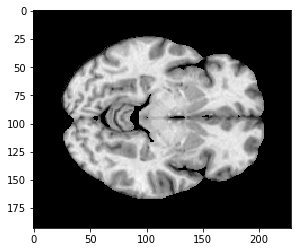

In [18]:
plt.imshow(img[0][:,:,70], cmap='gray')

# Define the classifier

In [19]:
class ClassificationModel3D(nn.Module):
    """The model we use in the paper."""

    def __init__(self, dropout=0.4, dropout2=0.4):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 8, 3)
        self.Conv_1_bn = nn.BatchNorm3d(8)
        self.Conv_1_mp = nn.MaxPool3d(2)
        self.Conv_2 = nn.Conv3d(8, 16, 3)
        self.Conv_2_bn = nn.BatchNorm3d(16)
        self.Conv_2_mp = nn.MaxPool3d(3)
        self.Conv_3 = nn.Conv3d(16, 32, 3)
        self.Conv_3_bn = nn.BatchNorm3d(32)
        self.Conv_3_mp = nn.MaxPool3d(2)
        self.Conv_4 = nn.Conv3d(32, 64, 3)
        self.Conv_4_bn = nn.BatchNorm3d(64)
        self.Conv_4_mp = nn.MaxPool3d(3)
        self.dense_1 = nn.Linear(5120, 128)
        self.dense_2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout2)

    def forward(self, x):
        x = self.relu(self.Conv_1_bn(self.Conv_1(x)))
        x = self.Conv_1_mp(x)
        x = self.relu(self.Conv_2_bn(self.Conv_2(x)))
        x = self.Conv_2_mp(x)
        x = self.relu(self.Conv_3_bn(self.Conv_3(x)))
        x = self.Conv_3_mp(x)
        x = self.relu(self.Conv_4_bn(self.Conv_4(x)))
        x = self.Conv_4_mp(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.dense_1(x))
        x = self.dropout2(x)
        x = self.dense_2(x)
        return x

In [20]:
net = ClassificationModel3D().cuda(gpu)

In [21]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 728898


# Training

In [22]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(4):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = ClassificationModel3D().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.CrossEntropyLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        plt.imshow(img.squeeze()[:,:,70], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            prediction_type="classification"
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=60,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [23]:
num_epochs = 200
min_iters = 3
ignore_epochs = 15
normalize = False
retain_metric = accuracy_score
metrics = [accuracy_score]

In [24]:
r = 0

In [25]:
check = ModelCheckpoint(path=model_path,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)
callbacks = [check, EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1_OHE


Starting trial 0
torch.Size([1, 193, 229, 193])
175


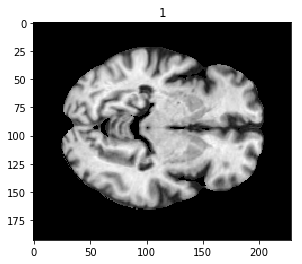

[0,    60] loss: 0.77046
[0,   120] loss: 0.72945
Time elapsed: 0h:1m:43s
train accuracy_score: 50.93 %
tensor([[[[[ 2.7221e-03, -2.3426e-03, -4.9928e-03],
           [ 7.2687e-03,  2.1895e-03, -9.9231e-04],
           [ 5.0693e-03,  1.1742e-03, -9.7307e-04]],

          [[ 1.0745e-02, -4.3186e-04,  1.5243e-03],
           [ 3.8719e-03, -5.3556e-03, -7.9576e-03],
           [-8.2282e-03, -8.7681e-03, -2.9832e-03]],

          [[ 7.3162e-03, -4.6082e-04, -4.1793e-03],
           [ 1.3357e-03, -1.0075e-02,  9.4900e-04],
           [-1.2312e-03, -1.2214e-02, -6.5313e-03]]]],



        [[[[ 1.7730e-03, -7.8781e-04, -6.2785e-04],
           [ 7.9231e-04, -1.3995e-03, -9.6758e-04],
           [ 9.1635e-04,  3.7616e-04, -6.7217e-05]],

          [[ 1.5894e-03,  8.4799e-04, -2.4266e-04],
           [ 7.8274e-04, -1.5266e-04,  8.1652e-05],
           [ 9.0051e-04,  1.2808e-03,  6.6106e-04]],

          [[ 6.8734e-04,  4.8240e-04,  1.0291e-03],
           [ 1.1977e-03,  1.3444e-03,  7.4090e-04]

val accuracy_score: 60.00 %
Val loss: 0.676732
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[3,    60] loss: 0.69582
[3,   120] loss: 0.69822
Time elapsed: 0h:7m:18s
train accuracy_score: 47.78 %
tensor([[[[[ 4.4019e-04, -4.2944e-04, -1.1478e-04],
           [ 2.1512e-04, -3.5999e-04, -6.5329e-04],
           [-1.8476e-03, -3.9075e-04, -5.5727e-04]],

          [[-5.1329e-04, -2.8179e-04, -1.5882e-05],
           [-1.0250e-03, -1.3188e-03, -2.5725e-04],
           [-1.2628e-03, -2.2454e-04,  3.5691e-04]],

          [[-8.8981e-04, -1.0456e-05,  8.2314e-05],
           [-2.5531e-04, -3.5256e-04, -4.5992e-04],
           [-2.5773e-03, -8.2342e-04, -1.2640e-03]]]],



        [[[[-1.4555e-04, -1.1651e-04, -3.2884e-04],
           [-4.5790e-05, -1.5493e-04, -1.5467e-04],
           [-1.5763e-04, -3.7271e-04, -3.6286e-04]],

          [[-4.2965e-05, -1.1277e-04, -1.5334e-04],
           [-1.1808e-04, -1.9941e-04,  4.9272e-05],
           [-2.4667e-04, -2.8065e-04, -3.234

[5,    60] loss: 0.69449
[5,   120] loss: 0.69399
Time elapsed: 0h:11m:1s
train accuracy_score: 54.81 %
tensor([[[[[ 4.1890e-03,  3.4730e-04, -4.0182e-03],
           [ 1.3071e-03, -5.3122e-03, -4.5729e-03],
           [-5.6348e-03,  2.5529e-03, -2.4043e-03]],

          [[-1.2350e-03, -3.2579e-03, -2.0125e-03],
           [ 9.2520e-04, -1.6700e-03, -5.2942e-03],
           [-2.3441e-03, -2.3440e-04, -2.7797e-03]],

          [[-4.5546e-03, -3.9639e-03,  5.1559e-04],
           [-2.3595e-03, -6.5492e-04, -3.6344e-03],
           [-1.0179e-02, -3.7451e-03, -2.6258e-03]]]],



        [[[[ 4.7772e-03,  2.4010e-03, -6.6054e-04],
           [ 3.3175e-03,  1.9078e-03,  1.9663e-04],
           [ 1.6383e-03,  1.0777e-03,  6.3847e-04]],

          [[ 5.1384e-03,  1.9757e-03,  4.6205e-04],
           [ 2.1185e-03,  1.8283e-03,  1.0592e-04],
           [ 7.5035e-04,  1.3728e-03,  4.5401e-04]],

          [[ 2.2856e-03,  6.4405e-04, -1.2596e-04],
           [ 1.4583e-03,  9.7416e-04,  3.3437e-04]

val accuracy_score: 40.00 %
Val loss: 0.718239
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[8,    60] loss: 0.66700
[8,   120] loss: 0.64206
Time elapsed: 0h:16m:32s
train accuracy_score: 61.41 %
tensor([[[[[-3.3230e-03, -2.1179e-03,  3.2768e-03],
           [-6.6261e-03, -3.7610e-03,  1.2782e-03],
           [-1.7262e-02, -6.4756e-03, -3.6899e-03]],

          [[-4.1094e-03, -2.0204e-03,  4.2462e-03],
           [-3.8529e-03, -3.9512e-03, -1.4300e-04],
           [-4.0657e-03, -1.3106e-03, -1.7339e-03]],

          [[ 1.3362e-04, -3.5785e-04,  4.1645e-03],
           [ 4.4598e-03,  6.9674e-04,  4.5031e-03],
           [-6.1116e-03,  9.3723e-04,  1.8389e-03]]]],



        [[[[ 2.4189e-03,  4.3774e-04, -4.2303e-04],
           [ 9.5557e-04,  4.6352e-05, -7.0420e-04],
           [ 6.5462e-04, -1.7121e-04, -1.1346e-03]],

          [[ 1.5522e-03,  1.6883e-03, -4.5254e-05],
           [ 1.0842e-03,  7.4115e-06, -1.3027e-04],
           [-1.9596e-04, -1.4639e-04, -1.62

[10,    60] loss: 0.62608
[10,   120] loss: 0.52780
Time elapsed: 0h:20m:17s
train accuracy_score: 69.15 %
tensor([[[[[-7.8442e-03, -7.5800e-03, -6.0120e-03],
           [-7.5438e-03, -8.4542e-03, -7.5224e-03],
           [-2.3689e-02, -9.0542e-03, -1.1572e-02]],

          [[-4.1442e-03,  7.1297e-04,  2.0211e-03],
           [-1.0603e-02, -3.7958e-03, -1.4106e-03],
           [-1.7586e-02, -4.4745e-03, -8.3326e-03]],

          [[-6.9455e-03, -1.3424e-04,  2.5356e-03],
           [-8.1952e-03, -5.7179e-04,  2.0566e-03],
           [-2.2202e-02, -4.7169e-03, -1.7792e-03]]]],



        [[[[ 3.3675e-03,  4.3633e-04, -3.8590e-04],
           [ 2.3384e-03,  1.2285e-04, -1.0624e-03],
           [ 2.0995e-03,  2.0949e-04, -9.3895e-04]],

          [[ 3.4216e-03,  1.4590e-03, -4.2090e-04],
           [ 2.8394e-03, -5.8007e-04, -3.0996e-04],
           [ 1.6010e-03, -5.5935e-04, -1.2499e-03]],

          [[ 1.7457e-03,  2.4912e-03,  4.2288e-04],
           [ 1.8624e-03, -3.9087e-05, -5.4606e-

val accuracy_score: 46.00 %
Val loss: 0.731752
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[13,    60] loss: 0.59713
[13,   120] loss: 0.49862
Time elapsed: 0h:25m:51s
train accuracy_score: 74.03 %
tensor([[[[[ 3.9524e-03, -1.1814e-03, -6.6409e-03],
           [-2.0280e-03, -9.9965e-03, -1.3072e-02],
           [-3.1198e-02, -1.7588e-02, -2.1124e-02]],

          [[ 2.1956e-03,  4.9903e-03, -1.3160e-03],
           [-6.7924e-03, -3.8680e-03, -3.3000e-03],
           [-2.4515e-02, -7.5290e-03, -4.3900e-03]],

          [[-4.3711e-03, -2.3282e-03,  1.1947e-03],
           [-4.1594e-03,  5.1957e-04,  1.5001e-03],
           [-2.5921e-02, -2.4753e-03,  2.9956e-03]]]],



        [[[[ 5.3177e-03,  2.7530e-03,  1.0965e-03],
           [ 1.3159e-03, -7.0661e-04,  1.7182e-03],
           [ 5.5312e-04,  6.3897e-05,  7.0922e-04]],

          [[ 4.8790e-03,  3.3424e-03,  3.2084e-04],
           [ 1.8929e-03,  2.9079e-04,  1.5296e-04],
           [ 1.2802e-03,  4.3311e-04,  3.

[15,    60] loss: 0.49564
[15,   120] loss: 0.49114
Time elapsed: 0h:29m:33s
train accuracy_score: 76.61 %
tensor([[[[[-4.4310e-03, -5.4018e-03, -2.0447e-03],
           [ 1.0691e-03, -6.3921e-03, -1.2628e-02],
           [-2.2706e-02, -1.6648e-02, -1.1367e-02]],

          [[-1.8217e-03,  1.8668e-03,  2.4184e-03],
           [-2.0148e-03, -5.7040e-03, -2.8411e-03],
           [-2.3495e-02, -1.2155e-02, -1.1211e-02]],

          [[-3.4477e-03,  3.9530e-03,  5.7132e-03],
           [-5.2641e-03, -1.7469e-03,  3.3454e-03],
           [-2.9896e-02, -8.7367e-03, -1.1623e-03]]]],



        [[[[ 3.8551e-03,  2.1471e-03,  1.4077e-03],
           [ 2.1390e-03,  5.1975e-04,  1.5250e-03],
           [ 5.7212e-04,  4.5943e-04,  3.7278e-07]],

          [[ 3.8663e-03,  3.2953e-03,  5.6848e-04],
           [ 2.5604e-03,  4.5185e-04, -2.8656e-04],
           [ 1.3321e-03,  1.9120e-04,  2.9830e-04]],

          [[ 4.1393e-03,  2.1255e-03,  4.4084e-04],
           [ 3.1083e-03,  6.1848e-04,  3.9677e-

val accuracy_score: 83.00 %
Val loss: 0.445741
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[18,    60] loss: 0.48623
[18,   120] loss: 0.47283
Time elapsed: 0h:35m:6s
train accuracy_score: 81.06 %
tensor([[[[[ 3.2179e-02,  4.0175e-02, -1.8388e-04],
           [ 3.7922e-02,  3.3751e-02,  2.1505e-02],
           [ 1.5178e-01,  5.6349e-02,  6.8306e-02]],

          [[ 6.9430e-04, -6.3880e-03, -2.0131e-02],
           [ 2.2175e-02,  1.4068e-02, -3.0826e-02],
           [ 7.6525e-02,  3.2160e-02,  1.3711e-02]],

          [[-1.3519e-02, -1.6771e-03, -1.8521e-02],
           [ 8.3468e-03,  7.6979e-03, -1.8942e-02],
           [ 1.0108e-01,  2.3220e-02, -2.1254e-02]]]],



        [[[[-8.0995e-03, -4.0485e-03, -3.1838e-03],
           [-1.5256e-03, -2.3152e-03, -9.9626e-03],
           [-1.4287e-03,  1.5359e-03, -1.0488e-02]],

          [[-3.3094e-03, -3.6553e-04, -2.1299e-04],
           [ 2.2427e-04,  6.9265e-04, -1.3514e-04],
           [ 3.3043e-04,  2.5315e-03, -7.6

[20,    60] loss: 0.39468
[20,   120] loss: 0.44995
Time elapsed: 0h:38m:47s
train accuracy_score: 85.80 %
tensor([[[[[ 1.0863e-02,  1.0240e-02,  6.0351e-03],
           [ 1.0206e-02, -4.3572e-03, -1.1469e-02],
           [-2.0451e-02, -2.4615e-02, -2.3985e-02]],

          [[ 2.3073e-03,  5.4707e-03,  3.8237e-03],
           [-5.4613e-03, -3.1730e-03, -3.4409e-03],
           [-1.2939e-02, -7.9779e-03, -1.9159e-02]],

          [[-3.1879e-03, -2.5703e-03, -3.6179e-04],
           [-5.4516e-03, -5.3986e-03, -2.9813e-03],
           [-2.0759e-02, -5.8613e-04, -7.4648e-03]]]],



        [[[[ 3.8141e-03,  8.6252e-04,  3.3237e-05],
           [ 1.9612e-03,  9.1121e-05, -5.4584e-04],
           [ 1.0557e-04, -6.6297e-04, -1.0852e-03]],

          [[ 3.0407e-03,  2.3646e-03,  1.6593e-04],
           [ 3.0291e-03, -8.0862e-05,  1.5074e-05],
           [ 8.8539e-04, -4.2409e-04, -6.5206e-04]],

          [[ 2.9733e-03,  1.5124e-03,  1.2694e-04],
           [ 2.3306e-03,  2.2500e-04,  1.8498e-

val accuracy_score: 79.00 %
Val loss: 0.401098
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[23,    60] loss: 0.44645
[23,   120] loss: 0.41398
Time elapsed: 0h:44m:21s
train accuracy_score: 82.35 %
tensor([[[[[ 4.5612e-03,  1.3636e-02,  1.8102e-02],
           [ 1.3681e-02, -1.3895e-02,  3.9396e-03],
           [ 8.4335e-04, -3.9053e-02, -2.7929e-02]],

          [[-1.1316e-03,  9.4710e-03,  1.9425e-02],
           [-7.4045e-03, -2.6541e-03,  1.6471e-03],
           [-1.9192e-02, -1.0040e-04, -9.8670e-03]],

          [[-5.8687e-03, -1.8147e-03,  2.0569e-02],
           [-1.5812e-02, -1.1863e-02,  9.3908e-03],
           [-3.7489e-02, -1.2178e-02,  1.6022e-03]]]],



        [[[[ 3.1107e-03, -4.4062e-04,  2.1478e-03],
           [-9.1445e-04, -1.2502e-03,  3.1879e-03],
           [-1.7417e-03, -8.3627e-04,  3.2717e-03]],

          [[ 3.1213e-03, -8.2961e-04, -4.9026e-04],
           [ 4.7038e-04, -2.3634e-04, -1.8946e-04],
           [-5.3329e-04, -1.0773e-03,  1.

[25,    60] loss: 0.36188
[25,   120] loss: 0.38150
Time elapsed: 0h:48m:5s
train accuracy_score: 85.22 %
tensor([[[[[-1.0788e-02, -6.7830e-02, -9.1959e-02],
           [ 3.4753e-02, -6.8146e-02, -1.0332e-01],
           [-1.8384e-01, -1.7443e-01, -1.6408e-01]],

          [[-1.6734e-02, -2.0065e-03,  9.1853e-03],
           [-2.6463e-02, -5.3687e-02, -1.0842e-01],
           [-7.2601e-02, -5.4966e-02, -1.1843e-01]],

          [[ 4.3744e-03, -1.7838e-02, -1.6847e-03],
           [-4.7276e-02, -2.7065e-02, -1.3082e-02],
           [-1.3934e-01, -5.8033e-02, -4.5263e-02]]]],



        [[[[ 9.1953e-03,  3.2365e-03,  4.9539e-03],
           [ 9.3655e-04, -1.1367e-03, -2.2482e-03],
           [-9.5626e-04, -7.7132e-03, -8.5131e-03]],

          [[ 3.0874e-03,  1.2793e-03, -3.3958e-03],
           [-2.3743e-03, -3.7508e-03, -2.3319e-03],
           [-3.8304e-03, -4.6323e-03, -8.1269e-03]],

          [[ 2.2423e-03, -3.0989e-04, -3.4416e-04],
           [-1.1817e-03, -2.3557e-04, -2.6373e-0

val accuracy_score: 81.00 %
Val loss: 0.386431
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[28,    60] loss: 0.35563
[28,   120] loss: 0.31672
Time elapsed: 0h:53m:51s
train accuracy_score: 85.80 %
tensor([[[[[ 1.3117e-01,  6.9735e-02,  3.7899e-02],
           [ 2.8865e-02, -1.9349e-02, -1.3241e-01],
           [ 3.3720e-02,  7.2970e-04, -2.1263e-01]],

          [[ 8.4488e-02, -2.5208e-02, -1.1385e-01],
           [ 8.7103e-02, -1.0751e-02, -4.9294e-02],
           [ 1.8793e-01,  4.4804e-02, -7.7191e-02]],

          [[ 4.1249e-02,  9.2782e-03, -4.1587e-02],
           [ 1.4888e-01,  2.1127e-02,  1.5287e-04],
           [ 3.6979e-01,  1.1578e-01,  2.5566e-02]]]],



        [[[[-6.3357e-03,  6.3930e-03, -1.8242e-02],
           [-2.9983e-03, -1.1843e-03, -1.4221e-02],
           [-2.1332e-03,  3.7241e-03, -1.1370e-02]],

          [[-1.1507e-02, -1.1271e-02, -4.8432e-03],
           [-1.0183e-03,  7.2574e-03,  4.4345e-03],
           [ 1.9689e-02,  1.0339e-02,  5.

[30,    60] loss: 0.28193
[30,   120] loss: 0.28301
Time elapsed: 0h:57m:40s
train accuracy_score: 89.10 %
tensor([[[[[ 5.6447e-03,  6.0866e-03,  7.7223e-03],
           [ 3.5553e-03, -5.3188e-03,  1.3891e-03],
           [ 1.2932e-03, -9.6720e-03, -8.3572e-03]],

          [[ 3.8318e-03,  5.6150e-03,  1.2869e-02],
           [ 5.7196e-03,  1.3717e-03,  4.3417e-03],
           [-2.8557e-03, -1.8845e-03, -5.4569e-03]],

          [[ 3.6055e-03,  5.7273e-04,  4.9413e-03],
           [ 1.4376e-03,  2.2734e-03,  4.9461e-03],
           [ 3.9562e-03, -2.6496e-03,  2.9569e-03]]]],



        [[[[ 2.3815e-04, -4.2855e-05, -6.3662e-05],
           [ 6.0304e-04,  1.8337e-04, -9.9521e-05],
           [-1.3484e-05, -3.8009e-04,  2.2625e-04]],

          [[ 9.9782e-04,  1.0208e-03,  1.1774e-04],
           [ 9.9931e-04,  1.0501e-04,  3.6487e-04],
           [-2.8184e-04, -3.1621e-04, -2.3211e-04]],

          [[ 1.3920e-03,  1.1054e-03, -3.5278e-04],
           [ 1.2948e-03,  5.0717e-04,  1.4981e-

val accuracy_score: 81.00 %
Val loss: 0.391441
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[33,    60] loss: 0.24296
[33,   120] loss: 0.27252
Time elapsed: 1h:3m:24s
train accuracy_score: 90.39 %
tensor([[[[[ 2.2956e-05,  3.3611e-05,  1.9384e-05],
           [-1.3605e-05, -1.1414e-05, -4.7072e-06],
           [ 5.0106e-05,  9.2067e-06, -1.9435e-05]],

          [[-2.0239e-05, -2.5024e-05, -3.5404e-05],
           [ 6.0537e-06, -1.9538e-06, -1.9490e-05],
           [-2.6565e-06, -1.7996e-06,  1.6981e-05]],

          [[-3.4575e-05, -3.1742e-05, -4.0329e-05],
           [-2.0005e-05, -1.2658e-05, -2.7483e-05],
           [ 4.4157e-06, -1.2067e-05, -2.2002e-05]]]],



        [[[[-1.0606e-05, -9.4794e-06, -1.8830e-05],
           [-4.2537e-06, -2.2244e-06,  6.7626e-06],
           [-1.0381e-05, -1.7120e-05, -9.6012e-06]],

          [[ 4.4073e-06,  9.6272e-06, -1.4490e-06],
           [-2.5407e-06, -1.1578e-05, -1.4044e-05],
           [-1.0477e-05, -8.9327e-06,  1.5

[35,    60] loss: 0.28776
[35,   120] loss: 0.17337
Time elapsed: 1h:7m:15s
train accuracy_score: 91.39 %
tensor([[[[[ 1.1233e-02,  9.2883e-03,  5.2940e-03],
           [ 7.5966e-03, -3.5930e-04, -9.0133e-03],
           [-4.6379e-03, -1.3468e-02, -1.2158e-02]],

          [[ 7.7821e-03,  3.4885e-03,  4.2570e-03],
           [ 3.9755e-03, -2.6351e-03, -8.5706e-04],
           [-6.4587e-03, -5.7604e-03, -1.1698e-02]],

          [[ 3.2070e-03,  3.4238e-04,  4.0409e-03],
           [-3.3427e-03, -2.7576e-03,  1.2693e-04],
           [-6.7612e-03, -5.5286e-03, -4.5891e-03]]]],



        [[[[ 1.5993e-03,  3.4662e-04,  7.0815e-05],
           [ 5.6714e-04,  6.9414e-06,  7.4285e-04],
           [-2.5505e-05, -3.0829e-04,  7.0599e-04]],

          [[ 5.9634e-04,  6.9641e-05, -5.4648e-04],
           [-1.5379e-04, -6.0563e-04, -8.1938e-05],
           [-6.5197e-04, -5.4057e-04,  5.3281e-04]],

          [[ 1.1627e-03,  4.8168e-04, -5.1266e-04],
           [ 4.7741e-04,  4.0318e-04, -3.7716e-0

val accuracy_score: 84.00 %
Val loss: 0.412112
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[38,    60] loss: 0.23698
[38,   120] loss: 0.13524
Time elapsed: 1h:12m:59s
train accuracy_score: 92.54 %
tensor([[[[[-4.3865e-04, -1.2428e-03, -4.9397e-04],
           [-4.1403e-04, -3.5279e-04, -7.6335e-04],
           [ 1.5404e-03,  9.2791e-04,  1.6095e-03]],

          [[-1.8819e-03, -2.5095e-04, -3.1489e-03],
           [-9.7815e-04,  4.0830e-04, -2.0341e-03],
           [ 1.1310e-04,  5.7119e-04, -4.3742e-04]],

          [[-2.4444e-03, -9.5835e-04, -1.6102e-03],
           [-2.9083e-03,  1.7344e-03, -1.0529e-03],
           [-6.0811e-03, -1.4497e-03, -7.8773e-04]]]],



        [[[[-6.6560e-04, -1.2031e-04, -1.6702e-04],
           [-1.9016e-04,  2.1860e-04, -3.2679e-06],
           [ 2.4887e-04,  1.1813e-04,  2.1575e-05]],

          [[-8.3671e-04, -3.5868e-04,  1.2426e-05],
           [-6.1354e-05,  7.2981e-05, -4.6435e-05],
           [ 1.4875e-04, -1.0815e-04,  1.

Finished fold.


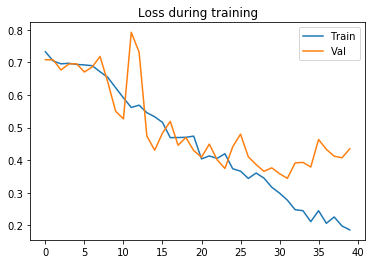

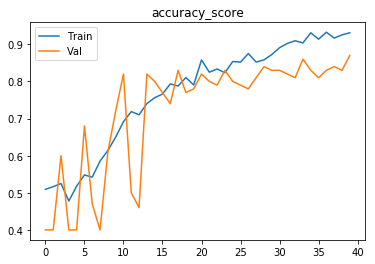

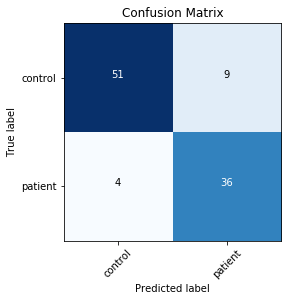

Starting trial 1
torch.Size([1, 193, 229, 193])
175


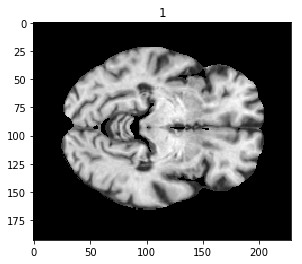

[0,    60] loss: 0.75976
[0,   120] loss: 0.73436
Time elapsed: 0h:1m:47s
train accuracy_score: 51.65 %
tensor([[[[[-5.1819e-03, -9.7396e-03, -1.2974e-02],
           [-3.3770e-03, -1.0226e-02, -1.0170e-02],
           [-4.8642e-03, -6.3232e-03, -7.5892e-03]],

          [[-1.9342e-03, -6.1747e-03, -1.1854e-02],
           [-3.9194e-03, -7.6393e-03, -1.1057e-02],
           [-5.1562e-03, -6.7267e-03, -7.3693e-03]],

          [[ 2.1568e-03, -4.5528e-03, -9.3306e-03],
           [-3.3827e-03, -6.8181e-03, -7.2822e-03],
           [-1.0988e-03, -3.8309e-03, -6.0653e-03]]]],



        [[[[-7.1114e-04, -1.2383e-04,  8.2875e-04],
           [-3.6071e-04,  5.9362e-04,  1.4375e-03],
           [ 2.7390e-04,  1.9585e-04,  4.3127e-03]],

          [[ 1.9604e-04, -9.8328e-04,  8.0266e-04],
           [-1.2820e-03, -3.8575e-05,  1.8540e-03],
           [-1.0055e-03, -1.7318e-05,  1.2630e-03]],

          [[-7.8612e-04, -1.5552e-04,  8.9186e-04],
           [-1.4166e-03, -2.8529e-03,  1.7938e-03]

val accuracy_score: 74.00 %
Val loss: 0.680240
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[3,    60] loss: 0.68079
[3,   120] loss: 0.69228
Time elapsed: 0h:7m:30s
train accuracy_score: 53.66 %
tensor([[[[[ 3.4760e-03,  2.3528e-03,  1.8862e-03],
           [ 1.7893e-03,  1.4760e-03,  1.0293e-03],
           [ 8.4064e-04,  6.0094e-04, -1.0175e-04]],

          [[ 2.6674e-03,  1.8172e-03,  1.4465e-03],
           [ 2.0995e-03,  1.3727e-03,  7.4528e-04],
           [ 1.4647e-03,  1.2923e-03,  1.6700e-04]],

          [[ 3.4531e-03,  2.1794e-03,  1.7080e-03],
           [ 2.4645e-03,  1.4882e-03,  7.6327e-04],
           [ 2.1396e-03,  1.3495e-03,  4.5421e-04]]]],



        [[[[-5.0228e-04, -4.5929e-04, -8.6964e-05],
           [-7.5257e-04, -4.3849e-04,  3.7792e-04],
           [-4.3780e-04,  5.3679e-04,  6.3969e-05]],

          [[-1.1913e-03, -9.0567e-04,  4.2771e-05],
           [-3.7784e-04,  1.0224e-05, -9.8502e-05],
           [-1.2560e-04,  6.3725e-05,  4.487

[5,    60] loss: 0.65797
[5,   120] loss: 0.67308
Time elapsed: 0h:11m:19s
train accuracy_score: 58.82 %
tensor([[[[[ 5.7214e-02,  3.9410e-02,  1.6706e-02],
           [ 4.6563e-02,  3.7701e-02,  1.2369e-02],
           [ 4.4629e-02,  3.0462e-02,  9.4139e-03]],

          [[ 5.6637e-02,  4.5918e-02,  3.4928e-02],
           [ 6.3118e-02,  3.9273e-02,  2.9693e-02],
           [ 5.0981e-02,  3.4879e-02,  1.9596e-02]],

          [[ 6.3703e-02,  4.4835e-02,  3.2167e-02],
           [ 6.4590e-02,  3.8086e-02,  2.7903e-02],
           [ 4.9110e-02,  2.7930e-02,  1.9936e-02]]]],



        [[[[ 1.0278e-02,  8.6329e-03,  6.8224e-03],
           [ 1.2447e-02,  5.3211e-03,  4.9688e-03],
           [ 1.4285e-02,  6.8202e-03,  4.1548e-03]],

          [[ 7.8538e-03,  4.3267e-03,  3.0748e-03],
           [ 1.0823e-02,  5.4190e-03,  5.0287e-03],
           [ 7.9911e-03,  7.1929e-03,  4.8815e-03]],

          [[ 8.6718e-04, -2.4163e-04, -1.7275e-03],
           [ 5.1771e-03,  2.0569e-03, -4.6809e-03

val accuracy_score: 81.00 %
Val loss: 0.601197
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[8,    60] loss: 0.61550
[8,   120] loss: 0.63276
Time elapsed: 0h:17m:1s
train accuracy_score: 66.71 %
tensor([[[[[-2.2205e-01, -2.1481e-01, -2.0090e-01],
           [-2.0324e-01, -1.9844e-01, -1.7808e-01],
           [-1.9012e-01, -1.9269e-01, -1.7204e-01]],

          [[-1.9794e-01, -1.8938e-01, -2.0151e-01],
           [-1.8065e-01, -1.6410e-01, -1.8172e-01],
           [-1.7868e-01, -1.6737e-01, -1.7304e-01]],

          [[-1.7701e-01, -1.6773e-01, -1.9516e-01],
           [-1.5688e-01, -1.4249e-01, -1.6806e-01],
           [-1.4620e-01, -1.3799e-01, -1.6409e-01]]]],



        [[[[-1.1510e-02, -5.0570e-03, -7.1432e-03],
           [-5.6038e-03, -3.5146e-03, -1.1682e-03],
           [-4.0314e-03, -4.8182e-03, -1.2915e-03]],

          [[-5.7954e-03, -1.4984e-06, -9.5558e-05],
           [-8.3891e-03, -2.8192e-04,  2.0458e-03],
           [-6.7814e-03, -1.0478e-03, -1.831

[10,    60] loss: 0.58335
[10,   120] loss: 0.59307
Time elapsed: 0h:20m:48s
train accuracy_score: 70.16 %
tensor([[[[[ 2.7193e-02,  1.9239e-02,  1.2867e-02],
           [ 2.0342e-02,  1.9438e-02,  1.5431e-02],
           [ 1.8836e-02,  2.2781e-02,  1.7847e-02]],

          [[ 2.5588e-02,  1.5457e-02,  1.3632e-02],
           [ 2.2100e-02,  1.2587e-02,  1.2751e-02],
           [ 1.8007e-02,  1.8419e-02,  1.6704e-02]],

          [[ 2.5943e-02,  1.8149e-02,  1.1999e-02],
           [ 2.1544e-02,  1.4067e-02,  8.6183e-03],
           [ 1.8928e-02,  1.4224e-02,  1.1030e-02]]]],



        [[[[-6.8928e-04, -1.5427e-03, -2.5997e-03],
           [-1.3312e-03, -1.9996e-03, -2.2607e-03],
           [-1.2781e-03, -1.9697e-03, -1.6699e-03]],

          [[ 1.2094e-03, -1.7227e-03, -2.5736e-03],
           [ 1.1604e-03, -1.9069e-03, -2.5168e-03],
           [ 7.1756e-04, -1.1724e-03, -1.0942e-03]],

          [[ 1.0491e-03, -5.1931e-04, -2.0348e-03],
           [ 1.4431e-03, -6.2142e-04, -1.7833e-

val accuracy_score: 59.00 %
Val loss: 0.624904
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[13,    60] loss: 0.53958
[13,   120] loss: 0.55674
Time elapsed: 0h:26m:25s
train accuracy_score: 73.31 %
tensor([[[[[ 4.8158e-01,  4.5472e-01,  4.4938e-01],
           [ 3.0833e-01,  4.0439e-01,  4.6269e-01],
           [ 2.8186e-01,  4.0196e-01,  4.8183e-01]],

          [[ 4.9126e-01,  4.6085e-01,  5.2596e-01],
           [ 3.2491e-01,  3.6539e-01,  5.1747e-01],
           [ 2.8092e-01,  3.7272e-01,  4.9934e-01]],

          [[ 5.2149e-01,  4.8417e-01,  5.9211e-01],
           [ 3.8629e-01,  4.1415e-01,  5.1000e-01],
           [ 2.9899e-01,  3.7204e-01,  5.1815e-01]]]],



        [[[[ 3.1250e-02,  2.3867e-02,  1.7800e-02],
           [ 2.6738e-02,  2.2194e-02,  1.2448e-02],
           [ 2.8974e-02,  2.2351e-02,  1.2461e-02]],

          [[ 2.2878e-02, -1.2946e-03, -7.2650e-03],
           [ 2.4971e-02,  8.0235e-03,  2.1135e-03],
           [ 2.4511e-02,  1.0128e-02,  2.

[15,    60] loss: 0.46643
[15,   120] loss: 0.48999
Time elapsed: 0h:30m:8s
train accuracy_score: 78.62 %
tensor([[[[[ 8.6800e-01,  9.4584e-01,  7.8376e-01],
           [ 1.4496e+00,  1.1130e+00,  4.8987e-01],
           [ 1.5801e+00,  6.3387e-01,  1.7046e-01]],

          [[ 7.6044e-01,  8.3411e-01,  3.1512e-01],
           [ 1.1842e+00,  9.3586e-01,  1.0517e-01],
           [ 1.1231e+00,  5.3153e-01,  2.1700e-02]],

          [[ 7.8359e-01,  7.0632e-01,  3.9931e-02],
           [ 9.4849e-01,  6.7099e-01, -1.1444e-02],
           [ 1.0022e+00,  4.3789e-01,  2.2217e-02]]]],



        [[[[-1.2364e-01, -7.0717e-02, -1.4473e-02],
           [-1.2931e-01, -3.3880e-02, -6.1238e-03],
           [-1.2787e-01, -7.5200e-02, -2.6632e-02]],

          [[-7.1983e-02,  9.4146e-03,  2.7786e-02],
           [-8.3233e-02,  7.6460e-03,  2.2621e-02],
           [-7.4082e-02, -2.8790e-02, -2.7309e-03]],

          [[-4.1029e-02,  2.2033e-02,  4.7685e-02],
           [-3.7447e-02,  2.1228e-03,  6.6452e-0

val accuracy_score: 89.00 %
Val loss: 0.385951
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[18,    60] loss: 0.42497
[18,   120] loss: 0.43877
Time elapsed: 0h:35m:44s
train accuracy_score: 82.35 %
tensor([[[[[-1.0288e-01, -7.1672e-02, -3.3593e-02],
           [-8.4329e-02, -6.0219e-02, -3.2145e-02],
           [-8.7016e-02, -7.6803e-02, -6.0026e-02]],

          [[-1.0161e-01, -7.4528e-02, -3.9063e-02],
           [-8.7729e-02, -5.7470e-02, -3.2046e-02],
           [-8.0719e-02, -6.9139e-02, -3.7768e-02]],

          [[-9.9953e-02, -7.6214e-02, -5.7293e-02],
           [-8.5609e-02, -5.7779e-02, -5.1665e-02],
           [-7.8522e-02, -6.1526e-02, -5.5628e-02]]]],



        [[[[-1.9604e-03, -2.2222e-03, -1.9651e-03],
           [-1.0059e-03, -1.2223e-03, -9.2962e-04],
           [-1.2418e-03, -1.6983e-03, -2.5559e-03]],

          [[ 4.3441e-04, -1.2848e-03, -2.0659e-03],
           [-7.0718e-04, -1.1140e-03, -8.9195e-04],
           [ 1.0050e-03, -9.6858e-04, -1.

[20,    60] loss: 0.36152
[20,   120] loss: 0.35807
Time elapsed: 0h:39m:27s
train accuracy_score: 84.65 %
tensor([[[[[-6.2431e-01, -8.3786e-01, -7.5304e-01],
           [-8.2202e-01, -5.2156e-01, -3.4728e-01],
           [-4.9851e-01, -1.6767e-02,  2.0183e-01]],

          [[-8.2991e-01, -9.4498e-01, -5.3617e-01],
           [-7.7849e-01, -7.7823e-01, -2.5505e-01],
           [-4.7871e-01, -2.4863e-01,  1.2740e-02]],

          [[-7.7628e-01, -9.2238e-01, -6.3234e-01],
           [-7.0778e-01, -6.9772e-01, -4.7260e-01],
           [-6.5353e-01, -4.0642e-01,  1.1543e-01]]]],



        [[[[ 2.1359e-02,  1.8087e-02,  1.0321e-03],
           [-1.2620e-02, -1.3601e-02, -2.0250e-03],
           [-4.7839e-02, -1.9223e-02, -1.4613e-02]],

          [[ 4.0666e-02,  9.1463e-03, -7.6115e-03],
           [ 1.0370e-03, -1.9238e-02, -8.3181e-03],
           [-4.3517e-02, -2.3204e-02, -7.2010e-03]],

          [[ 5.0956e-02,  1.0784e-02, -5.4189e-03],
           [ 1.3363e-03, -8.3831e-03, -1.2202e-

val accuracy_score: 90.00 %
Val loss: 0.331052
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[23,    60] loss: 0.34400
[23,   120] loss: 0.33474
Time elapsed: 0h:45m:4s
train accuracy_score: 88.38 %
tensor([[[[[-2.6938e-01, -2.4852e-01, -1.4689e-01],
           [-3.2330e-01, -2.3967e-01, -9.9087e-02],
           [-2.8309e-01, -7.5300e-02,  5.4653e-02]],

          [[-2.3217e-01, -2.1281e-01, -2.2252e-02],
           [-2.9418e-01, -2.1115e-01, -2.6866e-02],
           [-2.2196e-01, -1.3010e-01,  5.8492e-02]],

          [[-2.3541e-01, -1.6422e-01,  1.1941e-02],
           [-1.6847e-01, -1.4949e-01, -2.4440e-02],
           [-1.7338e-01, -9.1062e-02,  9.9261e-02]]]],



        [[[[ 1.5648e-02, -7.3985e-04, -1.7669e-02],
           [ 1.5236e-02,  9.2823e-04, -1.1000e-02],
           [ 1.1077e-02,  5.3680e-03, -6.8247e-03]],

          [[ 1.9080e-02, -5.2256e-03, -2.0420e-02],
           [ 1.6285e-02,  1.4972e-03, -9.7456e-03],
           [ 6.6380e-03,  1.6732e-03, -7.9

[25,    60] loss: 0.24906
[25,   120] loss: 0.30885
Time elapsed: 0h:48m:51s
train accuracy_score: 88.38 %
tensor([[[[[-3.2483e-01, -4.0767e-01, -4.6229e-01],
           [-3.6581e-01, -3.6520e-01, -3.4491e-01],
           [-3.3541e-01, -2.5688e-01, -2.2953e-01]],

          [[-3.1844e-01, -3.8807e-01, -3.8330e-01],
           [-3.4693e-01, -3.8593e-01, -3.5261e-01],
           [-3.4155e-01, -3.2388e-01, -2.8151e-01]],

          [[-3.3234e-01, -3.8496e-01, -3.7591e-01],
           [-3.5220e-01, -3.7590e-01, -3.1351e-01],
           [-3.5577e-01, -3.2354e-01, -3.0577e-01]]]],



        [[[[ 1.7328e-02,  8.8448e-03,  2.1977e-03],
           [ 1.6373e-02,  9.8908e-03,  2.0716e-03],
           [ 1.1066e-02,  7.5001e-03,  9.3633e-03]],

          [[ 1.5674e-02,  7.4819e-03, -1.1381e-03],
           [ 8.8992e-03,  2.2094e-03, -8.9042e-04],
           [ 3.6681e-03,  3.2317e-03,  3.6935e-03]],

          [[ 1.1265e-02,  2.5935e-03, -6.9727e-03],
           [ 4.3853e-03,  3.4317e-03, -2.5905e-

val accuracy_score: 91.00 %
Val loss: 0.334379
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[28,    60] loss: 0.24697
[28,   120] loss: 0.19208
Time elapsed: 0h:54m:34s
train accuracy_score: 91.68 %
tensor([[[[[-4.9989e+00, -5.2356e+00, -4.9553e+00],
           [-5.7747e+00, -4.8998e+00, -3.6678e+00],
           [-5.2300e+00, -3.3534e+00, -2.3363e+00]],

          [[-5.7141e+00, -5.3960e+00, -4.9021e+00],
           [-5.7372e+00, -5.6443e+00, -4.1501e+00],
           [-5.3693e+00, -3.9988e+00, -3.4563e+00]],

          [[-5.6180e+00, -5.6205e+00, -5.0067e+00],
           [-5.1706e+00, -5.0833e+00, -4.1838e+00],
           [-4.9575e+00, -4.3185e+00, -2.9482e+00]]]],



        [[[[ 2.3604e-01,  8.7970e-02, -1.0086e-02],
           [ 1.6599e-01,  4.0650e-02, -6.1224e-02],
           [ 4.2771e-02, -2.1487e-03, -4.8526e-02]],

          [[ 2.4672e-01,  1.1008e-01,  4.3143e-02],
           [ 1.7317e-01,  5.5815e-02, -4.8973e-02],
           [-6.8226e-03, -1.7616e-02, -6.

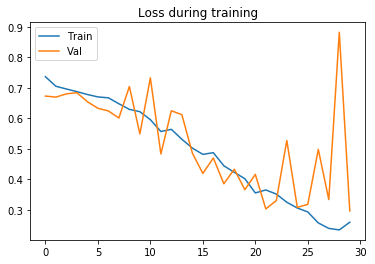

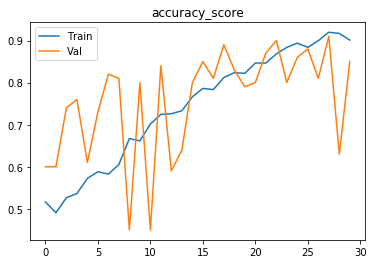

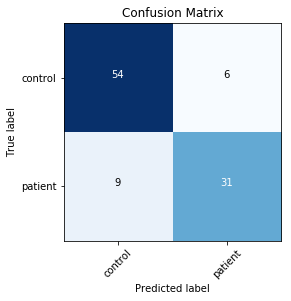

Starting trial 2
torch.Size([1, 193, 229, 193])
175


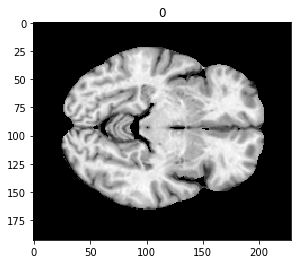

[0,    60] loss: 0.82498
[0,   120] loss: 0.69393
Time elapsed: 0h:1m:46s
train accuracy_score: 52.65 %
tensor([[[[[ 6.5374e-02,  7.0022e-02,  6.3031e-02],
           [ 1.0931e-01,  4.0493e-02, -2.1070e-03],
           [ 7.8754e-02,  6.7159e-02, -5.2747e-02]],

          [[ 4.3309e-02,  5.8323e-03, -1.8290e-02],
           [ 5.9207e-02,  1.1269e-03, -4.4969e-02],
           [ 3.4563e-02, -3.4254e-02, -8.5974e-02]],

          [[ 2.6501e-02, -9.8744e-03, -6.1281e-03],
           [ 3.5750e-02, -5.0067e-02, -8.7114e-02],
           [-2.0383e-02, -8.2927e-02, -9.0094e-02]]]],



        [[[[-1.2689e-02, -6.1403e-02, -8.6672e-04],
           [-3.9109e-02, -4.4803e-02, -1.3689e-02],
           [-5.3649e-02, -1.5826e-02, -1.7580e-02]],

          [[ 2.2296e-03, -4.9410e-02, -5.8227e-02],
           [-4.6874e-02, -3.0509e-02, -1.3298e-02],
           [-3.7052e-02, -2.4884e-02, -3.1101e-03]],

          [[ 2.1723e-02,  2.8891e-03, -1.5653e-02],
           [-3.4684e-02, -1.9601e-02, -8.8572e-03]

val accuracy_score: 76.00 %
Val loss: 0.636735
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[3,    60] loss: 0.64519
[3,   120] loss: 0.67857
Time elapsed: 0h:7m:30s
train accuracy_score: 59.11 %
tensor([[[[[-1.6166e-02,  7.1877e-03,  3.3278e-03],
           [-2.9594e-02,  3.7473e-02,  7.9373e-03],
           [-4.0335e-02,  4.4335e-02,  4.9750e-02]],

          [[-4.3371e-02, -2.9292e-02,  2.2537e-02],
           [-2.9452e-02,  1.0615e-02, -6.6769e-03],
           [-2.1227e-02,  4.9050e-02,  1.3020e-02]],

          [[-1.3085e-03, -4.3128e-02,  3.1908e-03],
           [-3.5037e-02,  2.3451e-03, -8.5855e-03],
           [-3.4987e-03, -1.0582e-02, -3.9257e-03]]]],



        [[[[-1.1953e-01, -1.0412e-01, -6.1885e-02],
           [-1.1559e-01, -8.4671e-02, -5.2380e-02],
           [-1.1083e-01, -2.1802e-02,  1.2313e-02]],

          [[-1.2979e-01, -8.9824e-02, -4.8177e-02],
           [-1.2413e-01, -1.0152e-01, -4.4478e-02],
           [-1.0411e-01, -4.2674e-02, -1.030

[5,    60] loss: 0.62259
[5,   120] loss: 0.56802
Time elapsed: 0h:11m:17s
train accuracy_score: 68.58 %
tensor([[[[[ 1.1782e-02,  1.0296e-02,  7.2157e-03],
           [ 1.9729e-02,  2.4970e-02,  1.6662e-02],
           [ 2.0813e-02,  3.1708e-02,  2.7842e-02]],

          [[ 4.3803e-04, -4.6578e-03,  2.0822e-03],
           [ 1.0345e-02,  1.3408e-02,  1.0068e-02],
           [ 9.9154e-03,  1.7095e-02,  1.6347e-02]],

          [[-1.0565e-02, -3.3144e-03, -1.1872e-02],
           [-6.3595e-03,  6.1936e-03, -4.2601e-03],
           [ 8.8378e-03,  9.2453e-03,  3.3973e-03]]]],



        [[[[-5.0362e-03, -3.5267e-03, -6.3389e-03],
           [ 1.0093e-02,  5.5680e-03, -1.0825e-03],
           [ 7.9862e-03,  3.5785e-03, -3.9404e-03]],

          [[-3.5072e-04, -3.8757e-03, -1.5108e-03],
           [ 2.4915e-03, -1.1986e-03, -3.3929e-03],
           [ 1.5832e-03, -3.4091e-03, -4.0790e-03]],

          [[-2.3258e-03, -1.5042e-03, -2.4394e-03],
           [ 1.9444e-04,  1.5334e-03,  3.0636e-03

val accuracy_score: 75.00 %
Val loss: 0.527375
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[8,    60] loss: 0.55933
[8,   120] loss: 0.57097
Time elapsed: 0h:16m:58s
train accuracy_score: 71.88 %
tensor([[[[[-1.6066e-02, -3.5359e-02, -8.8214e-03],
           [-4.4719e-02, -7.4703e-02, -2.8084e-02],
           [-5.8423e-02, -7.6305e-02, -4.3251e-02]],

          [[-3.1449e-03, -1.3089e-02, -3.6203e-03],
           [-4.1722e-02, -3.6999e-02, -2.1972e-02],
           [-5.5807e-02, -6.5512e-02, -2.6683e-02]],

          [[ 2.4955e-02, -3.5538e-03,  4.0311e-03],
           [-8.8048e-03, -3.5699e-02, -1.9378e-02],
           [-6.1246e-02, -4.4420e-02, -1.7347e-02]]]],



        [[[[-2.0826e-02, -4.3846e-02, -3.2491e-02],
           [-3.8770e-02, -3.5317e-02,  1.6340e-03],
           [-3.5909e-02, -2.9161e-03,  4.5669e-02]],

          [[-2.3428e-02, -4.6915e-02, -3.5781e-02],
           [-4.7141e-02, -3.5138e-02, -1.0081e-02],
           [-4.1321e-02, -1.4710e-02,  2.24

[10,    60] loss: 0.51907
[10,   120] loss: 0.59264
Time elapsed: 0h:20m:45s
train accuracy_score: 73.89 %
tensor([[[[[ 2.2634e-01,  1.3771e-01,  3.5990e-02],
           [ 3.7204e-01,  4.0042e-01,  1.4059e-01],
           [ 4.5567e-01,  4.0042e-01,  2.2203e-01]],

          [[ 5.6994e-02,  8.1004e-03, -6.3029e-05],
           [ 2.9532e-01,  1.7624e-01,  1.4892e-01],
           [ 3.8586e-01,  3.3471e-01,  1.9603e-01]],

          [[-1.3556e-01,  1.8500e-02,  4.0302e-02],
           [ 8.1996e-02,  1.2775e-01,  1.4757e-01],
           [ 2.8703e-01,  1.8279e-01,  1.7834e-01]]]],



        [[[[-1.3625e-01, -5.1816e-02, -9.3012e-02],
           [ 2.7118e-02, -4.6865e-02, -1.3692e-01],
           [ 9.2961e-02, -4.0244e-02, -2.1624e-01]],

          [[-9.0899e-02, -4.5547e-02, -6.7191e-02],
           [ 1.2795e-02,  4.1679e-02, -1.9377e-02],
           [ 7.6215e-02,  4.2709e-02, -9.6624e-02]],

          [[-1.0120e-01, -3.0952e-02, -2.6811e-02],
           [ 1.0269e-02,  6.1910e-02,  5.7075e-

val accuracy_score: 83.00 %
Val loss: 0.429474
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[13,    60] loss: 0.48845
[13,   120] loss: 0.50640
Time elapsed: 0h:26m:26s
train accuracy_score: 76.90 %
tensor([[[[[-4.3760e-01, -1.7375e-01, -1.0077e-02],
           [-6.4106e-01, -5.5076e-01, -1.8234e-01],
           [-8.1775e-01, -6.0468e-01, -3.1888e-01]],

          [[-3.0742e-01, -1.4575e-02,  1.4172e-01],
           [-5.7720e-01, -1.9084e-01, -7.6715e-02],
           [-7.2837e-01, -4.4193e-01, -6.8076e-02]],

          [[-1.5034e-01, -7.4246e-02,  6.0988e-02],
           [-3.9622e-01, -1.9595e-01, -5.3114e-02],
           [-6.4662e-01, -3.3559e-01, -1.4122e-01]]]],



        [[[[ 3.5598e-01,  2.5596e-01,  2.5544e-01],
           [ 3.3516e-01,  2.6231e-01,  4.2080e-01],
           [ 3.7679e-01,  4.2568e-01,  7.1625e-01]],

          [[ 1.8280e-01,  1.4641e-01,  6.8734e-02],
           [ 1.4376e-01,  1.1646e-01,  1.8291e-01],
           [ 2.4874e-01,  2.4050e-01,  3.

[15,    60] loss: 0.41765
[15,   120] loss: 0.47934
Time elapsed: 0h:30m:16s
train accuracy_score: 81.64 %
tensor([[[[[ 9.1245e-02,  3.9880e-02,  3.8219e-03],
           [ 1.0094e-01,  6.4803e-02,  5.9633e-03],
           [ 1.0085e-01,  5.3013e-02,  8.4915e-03]],

          [[ 7.5753e-02,  3.0751e-02,  3.5051e-03],
           [ 8.9022e-02,  3.6943e-02,  2.0019e-03],
           [ 8.1930e-02,  3.5783e-02,  5.7216e-03]],

          [[ 4.9260e-02,  2.9997e-02,  2.7201e-04],
           [ 5.7999e-02,  3.0603e-02,  1.1769e-02],
           [ 6.7281e-02,  2.8079e-02,  1.9169e-02]]]],



        [[[[-1.0216e-01, -1.0696e-01, -9.1159e-02],
           [-1.0253e-01, -1.0285e-01, -9.3439e-02],
           [-1.1027e-01, -8.1984e-02, -1.0514e-01]],

          [[-1.0344e-01, -9.4861e-02, -7.4082e-02],
           [-8.0339e-02, -7.9511e-02, -8.2957e-02],
           [-9.4421e-02, -6.4914e-02, -7.5921e-02]],

          [[-8.3269e-02, -7.1301e-02, -4.9822e-02],
           [-7.0976e-02, -5.9367e-02, -3.5731e-

val accuracy_score: 84.00 %
Val loss: 0.382647
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[18,    60] loss: 0.42463
[18,   120] loss: 0.38701
Time elapsed: 0h:36m:5s
train accuracy_score: 82.21 %
tensor([[[[[-3.5816e-01, -1.4703e-01,  5.6622e-02],
           [-5.9326e-01, -4.8162e-01, -4.1469e-02],
           [-7.4747e-01, -5.0128e-01, -1.1295e-01]],

          [[-2.7179e-01, -8.3938e-02,  8.1248e-02],
           [-4.6068e-01, -2.7401e-01, -4.0990e-02],
           [-5.8019e-01, -4.5488e-01, -9.2183e-02]],

          [[-1.7308e-01, -1.3861e-01, -1.1717e-02],
           [-3.5149e-01, -3.1522e-01, -1.4739e-01],
           [-5.7736e-01, -3.6389e-01, -1.5567e-01]]]],



        [[[[ 4.5219e-01,  1.3863e-01,  1.2501e-02],
           [ 4.3966e-01,  1.9864e-01,  2.0125e-01],
           [ 6.2045e-01,  4.5582e-01,  5.1321e-01]],

          [[ 3.9993e-01,  6.3704e-02, -3.3105e-02],
           [ 3.7755e-01,  2.4634e-01,  2.0080e-01],
           [ 6.7419e-01,  4.6541e-01,  4.9

[20,    60] loss: 0.37014
[20,   120] loss: 0.39787
Time elapsed: 0h:39m:56s
train accuracy_score: 84.79 %
tensor([[[[[-3.8911e-02, -2.0600e-02, -5.7400e-03],
           [-9.3719e-02, -6.7179e-02, -4.3002e-02],
           [-1.1660e-01, -9.2918e-02, -5.1542e-02]],

          [[-2.2136e-02,  1.0673e-02,  2.0864e-02],
           [-5.6917e-02, -3.0294e-02, -1.0285e-02],
           [-1.0815e-01, -7.0678e-02, -2.9441e-02]],

          [[ 7.9945e-03,  1.4983e-02,  1.7094e-02],
           [-2.5552e-02, -2.4465e-02, -9.4068e-03],
           [-8.9193e-02, -4.3784e-02, -7.6615e-03]]]],



        [[[[ 1.3552e-01,  5.6941e-02,  2.0795e-02],
           [ 1.0149e-01,  5.7181e-02,  1.5696e-02],
           [ 1.0377e-01,  7.4764e-02,  3.9262e-02]],

          [[ 1.4201e-01,  6.2027e-02,  3.9749e-02],
           [ 1.3055e-01,  6.0206e-02,  2.6423e-02],
           [ 1.1328e-01,  7.7545e-02,  3.4141e-02]],

          [[ 1.4727e-01,  9.0841e-02,  4.6142e-02],
           [ 1.2267e-01,  6.7012e-02,  3.8988e-

val accuracy_score: 82.00 %
Val loss: 0.380025
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[23,    60] loss: 0.36493
[23,   120] loss: 0.31667
Time elapsed: 0h:45m:44s
train accuracy_score: 88.09 %
tensor([[[[[-2.8603e-03, -1.8314e-03, -4.4120e-04],
           [-1.0751e-02, -9.9003e-03, -4.9250e-03],
           [-1.1926e-02, -9.3467e-03, -4.2658e-03]],

          [[ 2.5266e-03,  7.0476e-03,  7.7336e-03],
           [-2.1214e-03,  5.9394e-04, -3.1079e-03],
           [-4.1953e-03, -9.8709e-04, -3.6706e-03]],

          [[ 7.7102e-03,  3.9005e-03,  1.6108e-03],
           [ 3.0434e-03, -1.3762e-03, -8.3091e-03],
           [-1.8703e-03, -2.7922e-03, -1.1936e-02]]]],



        [[[[-3.0420e-04, -5.7356e-03, -6.4352e-03],
           [ 7.3124e-03,  1.2464e-02,  1.4748e-02],
           [ 2.6517e-02,  3.0438e-02,  2.6655e-02]],

          [[-5.1014e-03, -1.0143e-02, -1.3358e-02],
           [ 6.5264e-03,  1.2368e-04, -7.5424e-04],
           [ 1.4832e-02,  1.5257e-02,  9.

[25,    60] loss: 0.33720
[25,   120] loss: 0.31437
Time elapsed: 0h:49m:34s
train accuracy_score: 85.65 %
tensor([[[[[-3.4861e-01, -1.2359e-01,  4.4553e-02],
           [-6.8330e-01, -6.3192e-01, -1.5016e-01],
           [-9.9738e-01, -6.9590e-01, -2.0080e-01]],

          [[-3.3504e-01, -4.9699e-02,  1.1773e-01],
           [-7.1989e-01, -3.9787e-01, -1.1164e-01],
           [-9.0794e-01, -6.2368e-01, -1.7902e-01]],

          [[-7.4558e-02,  1.5816e-02,  7.1278e-02],
           [-4.6294e-01, -2.5521e-01, -4.5830e-02],
           [-9.1631e-01, -4.8182e-01, -1.5366e-01]]]],



        [[[[ 2.0137e-02, -4.7212e-01, -5.8125e-01],
           [-4.7105e-01, -1.9752e-01,  4.2150e-02],
           [ 6.9638e-02,  4.1597e-01,  5.9460e-01]],

          [[-1.2155e-01, -6.8052e-01, -7.7634e-01],
           [-1.9885e-01, -4.4053e-01, -3.3028e-01],
           [ 8.3543e-02,  2.7145e-01,  2.3362e-01]],

          [[-2.0275e-01, -6.0563e-01, -1.0835e+00],
           [-1.6903e-02, -5.8900e-01, -6.8801e-

val accuracy_score: 80.00 %
Val loss: 0.428375
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[28,    60] loss: 0.26912
[28,   120] loss: 0.25171
Time elapsed: 0h:55m:22s
train accuracy_score: 90.39 %
tensor([[[[[-9.9146e-02, -4.8664e-02, -3.4199e-02],
           [-2.1547e-01, -1.8753e-01, -9.2216e-02],
           [-3.1921e-01, -2.4354e-01, -7.9880e-02]],

          [[-6.0937e-02, -1.1549e-03,  3.3227e-02],
           [-2.0033e-01, -5.9507e-02,  5.5711e-03],
           [-3.2122e-01, -1.3380e-01,  2.7910e-02]],

          [[-3.5260e-02,  3.1704e-02,  3.9852e-02],
           [-1.4768e-01, -3.5582e-02,  1.0963e-02],
           [-2.7307e-01, -7.3442e-02,  3.6066e-02]]]],



        [[[[ 3.3916e-02, -5.6968e-02, -1.3196e-01],
           [ 7.4451e-02, -2.2161e-02,  2.3112e-02],
           [ 1.7439e-01,  1.5987e-01,  1.7985e-01]],

          [[ 1.3442e-01,  8.2873e-02,  3.0956e-02],
           [ 1.3582e-01,  1.7834e-01,  1.3946e-01],
           [ 2.4168e-01,  3.4951e-01,  3.

[30,    60] loss: 0.32270
[30,   120] loss: 0.21263
Time elapsed: 0h:59m:16s
train accuracy_score: 91.25 %
tensor([[[[[ 4.2794e-03,  1.0711e-03, -9.8515e-04],
           [ 5.5334e-03,  2.5713e-03,  4.1102e-04],
           [ 5.5503e-03,  2.9318e-03,  1.6767e-03]],

          [[ 3.1448e-03, -1.6097e-05, -8.4887e-04],
           [ 5.3599e-03,  1.4101e-03,  4.9337e-04],
           [ 5.8758e-03,  2.9318e-03,  1.8284e-03]],

          [[ 1.9567e-03, -3.5312e-05, -4.4152e-04],
           [ 3.6896e-03,  1.4970e-03,  1.2253e-03],
           [ 5.1014e-03,  2.4874e-03,  2.0188e-03]]]],



        [[[[-9.7397e-03, -5.5329e-03, -2.3215e-03],
           [-7.6623e-03, -6.1899e-03, -5.5412e-03],
           [-1.0781e-02, -8.7878e-03, -8.9728e-03]],

          [[-8.2282e-03, -6.1226e-03, -3.2045e-03],
           [-8.7309e-03, -7.6615e-03, -5.9293e-03],
           [-1.2427e-02, -1.0353e-02, -8.3590e-03]],

          [[-8.4261e-03, -6.6465e-03, -4.3954e-03],
           [-9.9897e-03, -7.9926e-03, -7.0821e-

val accuracy_score: 81.00 %
Val loss: 0.420683
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[33,    60] loss: 0.18964
[33,   120] loss: 0.19281
Time elapsed: 1h:5m:5s
train accuracy_score: 92.11 %
tensor([[[[[-5.9957e-05,  2.0986e-04,  1.6914e-06],
           [-7.5097e-04, -9.2210e-04, -3.3144e-04],
           [-1.7537e-03, -1.1539e-03, -4.7887e-04]],

          [[-8.5451e-05,  3.9474e-04,  8.4848e-05],
           [-8.4542e-04, -3.3832e-04, -4.3501e-06],
           [-1.5934e-03, -8.5446e-04,  1.2985e-04]],

          [[ 1.4588e-04,  3.8150e-04, -1.3732e-04],
           [-5.2034e-04, -2.2333e-04, -1.9434e-04],
           [-1.2523e-03, -3.5707e-04,  2.6299e-04]]]],



        [[[[ 8.0208e-04, -4.8565e-04, -8.5622e-04],
           [ 1.0802e-03,  4.1824e-04,  1.4855e-03],
           [ 2.6808e-03,  2.5476e-03,  2.8335e-03]],

          [[ 1.7040e-03,  6.6358e-04, -5.3355e-05],
           [ 1.4033e-03,  1.5544e-03,  1.6027e-03],
           [ 2.8925e-03,  3.1464e-03,  3.58

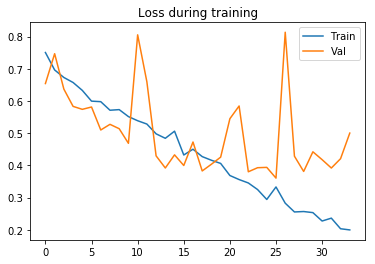

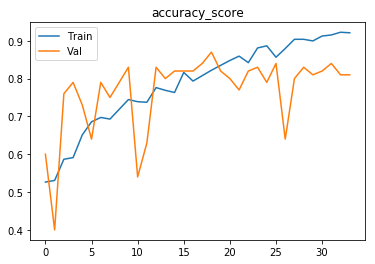

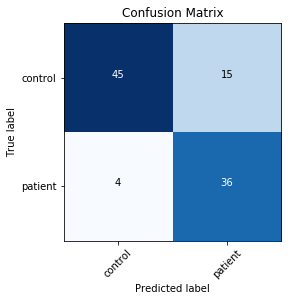

Starting trial 3
torch.Size([1, 193, 229, 193])
175


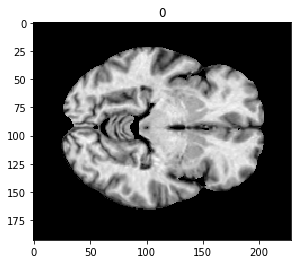

[0,    60] loss: 0.75768
[0,   120] loss: 0.75380
Time elapsed: 0h:1m:47s
train accuracy_score: 48.78 %
tensor([[[[[ 1.5031e-02, -1.7786e-02, -2.9507e-02],
           [-1.3737e-02, -1.7560e-02, -2.7379e-02],
           [ 1.7342e-03,  7.9124e-04, -2.7345e-02]],

          [[ 2.7553e-02,  5.2148e-03,  3.1958e-03],
           [ 4.1035e-02,  3.1895e-02, -5.0155e-03],
           [ 3.3984e-03,  3.4218e-04,  2.8400e-03]],

          [[ 1.2390e-02,  3.6042e-02,  3.9147e-02],
           [ 4.4755e-02,  6.5505e-04,  1.4321e-02],
           [ 2.0333e-02,  2.5171e-04, -1.2182e-02]]]],



        [[[[ 1.4393e-01,  1.5527e-01,  1.7893e-01],
           [ 1.2992e-01,  1.4508e-01,  1.5688e-01],
           [ 1.4010e-01,  1.4299e-01,  1.6126e-01]],

          [[ 1.3935e-01,  1.2394e-01,  1.5161e-01],
           [ 1.1848e-01,  1.1292e-01,  1.1977e-01],
           [ 1.2482e-01,  1.1960e-01,  1.2390e-01]],

          [[ 1.1216e-01,  1.1244e-01,  9.3472e-02],
           [ 9.4796e-02,  1.1072e-01,  8.0141e-02]

val accuracy_score: 60.00 %
Val loss: 0.665261
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[3,    60] loss: 0.70593
[3,   120] loss: 0.68629
Time elapsed: 0h:7m:31s
train accuracy_score: 52.37 %
tensor([[[[[-5.9853e-02, -4.1473e-02, -3.9030e-03],
           [-5.8350e-02, -3.4855e-02, -6.5389e-03],
           [-3.8765e-02, -2.8278e-02,  1.0173e-02]],

          [[-7.5926e-02, -2.6780e-02,  1.2303e-02],
           [-4.4808e-02, -1.5655e-02, -3.1169e-03],
           [-2.3303e-02, -1.5360e-02,  1.7294e-02]],

          [[-4.5712e-02, -3.3814e-02,  7.1761e-03],
           [-7.0690e-02, -8.9736e-03,  2.4732e-02],
           [-4.7760e-02, -2.6354e-02,  1.3410e-02]]]],



        [[[[-7.7482e-02, -6.4985e-02, -5.3910e-02],
           [-7.0032e-02, -4.0290e-02, -4.0229e-02],
           [-6.1010e-02, -5.1729e-02, -3.4273e-02]],

          [[-5.7121e-02, -5.9651e-02, -6.7994e-02],
           [-4.7204e-02, -5.6469e-02, -4.1806e-02],
           [-5.5784e-02, -4.5947e-02, -3.067

[5,    60] loss: 0.69589
[5,   120] loss: 0.67778
Time elapsed: 0h:11m:20s
train accuracy_score: 54.81 %
tensor([[[[[-1.2456e-01, -9.3121e-02, -7.8887e-02],
           [-1.0528e-01, -9.6217e-02, -7.2365e-02],
           [-1.1271e-01, -9.5606e-02, -1.0308e-01]],

          [[-1.2483e-01, -9.4978e-02, -6.3485e-02],
           [-1.0258e-01, -9.5920e-02, -7.2034e-02],
           [-1.0710e-01, -1.0280e-01, -9.2641e-02]],

          [[-1.1060e-01, -9.9966e-02, -7.8371e-02],
           [-9.7526e-02, -9.3620e-02, -8.4558e-02],
           [-1.0036e-01, -1.0230e-01, -9.9996e-02]]]],



        [[[[-8.1637e-02, -6.3869e-02, -6.4250e-02],
           [-6.1224e-02, -6.1802e-02, -6.1332e-02],
           [-4.4851e-02, -5.8088e-02, -4.3456e-02]],

          [[-5.1539e-02, -4.6799e-02, -6.3703e-02],
           [-5.4984e-02, -4.9487e-02, -4.6020e-02],
           [-4.9026e-02, -5.5027e-02, -4.1894e-02]],

          [[-5.6819e-02, -5.2385e-02, -5.1539e-02],
           [-5.9789e-02, -5.3642e-02, -4.3300e-02

val accuracy_score: 40.00 %
Val loss: 0.724308
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[8,    60] loss: 0.66183
[8,   120] loss: 0.66732
Time elapsed: 0h:17m:4s
train accuracy_score: 60.40 %
tensor([[[[[-4.5898e-01, -4.2469e-01, -3.2149e-01],
           [-4.4406e-01, -3.6909e-01, -3.1528e-01],
           [-3.8025e-01, -3.3015e-01, -3.1509e-01]],

          [[-4.5478e-01, -4.0312e-01, -3.0893e-01],
           [-4.2364e-01, -3.6417e-01, -3.0113e-01],
           [-3.7562e-01, -3.0870e-01, -2.9705e-01]],

          [[-4.0481e-01, -3.7183e-01, -2.7710e-01],
           [-3.8815e-01, -3.0704e-01, -2.8374e-01],
           [-3.3654e-01, -2.9238e-01, -2.6804e-01]]]],



        [[[[-4.3490e-02, -1.0044e-02, -3.5974e-03],
           [-2.3430e-02,  7.8267e-04,  9.6504e-03],
           [-6.1395e-03,  4.3829e-03,  1.2245e-02]],

          [[-3.6838e-02, -1.3803e-02, -9.6912e-03],
           [-3.8878e-02, -8.8267e-03, -1.4168e-03],
           [-1.2691e-02, -1.0685e-02,  1.374

[10,    60] loss: 0.64145
[10,   120] loss: 0.62138
Time elapsed: 0h:20m:52s
train accuracy_score: 65.28 %
tensor([[[[[-8.9704e-01, -8.1745e-01, -6.3475e-01],
           [-8.3666e-01, -7.1423e-01, -5.6061e-01],
           [-6.9394e-01, -5.7724e-01, -5.5661e-01]],

          [[-8.8651e-01, -7.3602e-01, -5.6133e-01],
           [-8.4233e-01, -6.9473e-01, -5.6859e-01],
           [-7.2110e-01, -5.8770e-01, -5.6550e-01]],

          [[-8.4636e-01, -7.3722e-01, -5.8646e-01],
           [-7.7969e-01, -6.5874e-01, -5.2938e-01],
           [-7.1054e-01, -6.0589e-01, -5.2108e-01]]]],



        [[[[-1.1798e-01, -8.9165e-02, -1.0406e-01],
           [-1.1732e-01, -1.0585e-01, -1.1673e-01],
           [-1.0713e-01, -1.0541e-01, -1.1534e-01]],

          [[-1.2262e-01, -9.0750e-02, -1.0038e-01],
           [-1.1722e-01, -1.0120e-01, -1.0504e-01],
           [-1.1299e-01, -1.1596e-01, -9.4385e-02]],

          [[-1.3168e-01, -1.2902e-01, -1.1214e-01],
           [-1.2954e-01, -1.2416e-01, -1.2626e-

val accuracy_score: 44.00 %
Val loss: 0.772320
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[13,    60] loss: 0.54486
[13,   120] loss: 0.49595
Time elapsed: 0h:26m:37s
train accuracy_score: 73.03 %
tensor([[[[[ 3.0738e-01,  2.7370e-01,  1.8320e-01],
           [ 3.1387e-01,  2.5360e-01,  1.7203e-01],
           [ 2.7495e-01,  1.9254e-01,  1.5704e-01]],

          [[ 3.0147e-01,  2.3702e-01,  1.3575e-01],
           [ 3.1745e-01,  2.4867e-01,  1.6786e-01],
           [ 2.8105e-01,  2.1717e-01,  1.7186e-01]],

          [[ 2.9285e-01,  2.5971e-01,  1.6503e-01],
           [ 2.7353e-01,  2.2338e-01,  1.8058e-01],
           [ 2.6483e-01,  2.4018e-01,  1.8798e-01]]]],



        [[[[ 6.5603e-02,  3.7148e-02,  2.9885e-02],
           [ 4.5547e-02,  2.5394e-02,  7.8484e-03],
           [ 3.0887e-02,  9.3820e-03, -1.5289e-02]],

          [[ 7.5575e-02,  4.8031e-02,  3.0149e-02],
           [ 4.8885e-02,  4.2398e-02,  1.6725e-03],
           [ 4.5190e-02,  2.7855e-02,  5.

[15,    60] loss: 0.50264
[15,   120] loss: 0.49194
Time elapsed: 0h:30m:25s
train accuracy_score: 75.47 %
tensor([[[[[-2.9899e+00, -2.6325e+00, -2.0794e+00],
           [-2.8122e+00, -2.2992e+00, -1.8131e+00],
           [-2.3139e+00, -1.8953e+00, -1.6773e+00]],

          [[-2.7931e+00, -2.2532e+00, -1.7469e+00],
           [-2.7274e+00, -2.1007e+00, -1.7281e+00],
           [-2.2456e+00, -1.8119e+00, -1.6395e+00]],

          [[-2.6490e+00, -2.1533e+00, -1.6657e+00],
           [-2.3834e+00, -1.9091e+00, -1.6862e+00],
           [-2.1942e+00, -1.8030e+00, -1.6807e+00]]]],



        [[[[ 2.2838e-02,  8.9471e-02,  5.9379e-02],
           [ 9.1463e-03,  7.3924e-02, -1.9126e-04],
           [ 4.0272e-02, -7.4613e-03, -8.3605e-02]],

          [[-1.6911e-03,  4.8977e-02,  6.5550e-03],
           [-3.4833e-02,  3.7806e-02, -6.0670e-03],
           [-6.2679e-02, -4.7050e-02, -8.6645e-02]],

          [[-6.8694e-02, -3.5244e-02, -8.3340e-02],
           [-9.4952e-02, -4.2858e-02, -3.4805e-

val accuracy_score: 75.00 %
Val loss: 0.476376
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[18,    60] loss: 0.47726
[18,   120] loss: 0.47126
Time elapsed: 0h:36m:7s
train accuracy_score: 80.49 %
tensor([[[[[-7.2110e-01, -7.3779e-01, -4.6736e-01],
           [-7.4351e-01, -5.3389e-01, -2.0935e-01],
           [-4.2789e-01, -1.8935e-01, -8.8705e-02]],

          [[-5.9009e-01, -3.6533e-01, -8.7500e-02],
           [-6.2761e-01, -3.6244e-01, -9.8395e-02],
           [-3.9276e-01, -8.5571e-02,  3.0964e-02]],

          [[-4.0935e-01, -1.1871e-01,  1.1515e-01],
           [-2.6495e-01, -1.0218e-01,  7.2450e-02],
           [-2.6864e-01, -2.5092e-02,  2.1645e-01]]]],



        [[[[ 7.5414e-02,  1.7273e-01,  1.5361e-01],
           [ 8.4383e-02,  1.7128e-01,  1.4333e-01],
           [ 7.8364e-02,  1.0036e-01,  9.6563e-02]],

          [[ 3.6367e-03,  8.6404e-02,  8.7335e-02],
           [ 8.7994e-03,  7.7976e-02,  9.3560e-02],
           [ 1.5540e-02,  5.1371e-02,  4.3

[20,    60] loss: 0.35876
[20,   120] loss: 0.38245
Time elapsed: 0h:39m:56s
train accuracy_score: 84.07 %
tensor([[[[[ 1.0023e-01,  1.0424e-01,  8.6888e-02],
           [ 8.7432e-02,  8.5016e-02,  7.3141e-02],
           [ 6.2499e-02,  6.1045e-02,  4.9685e-02]],

          [[ 1.0451e-01,  9.9013e-02,  7.7228e-02],
           [ 9.1260e-02,  8.7780e-02,  6.8603e-02],
           [ 7.3667e-02,  6.0945e-02,  4.9986e-02]],

          [[ 9.4003e-02,  8.3520e-02,  7.0869e-02],
           [ 7.3742e-02,  6.7732e-02,  5.5409e-02],
           [ 6.9324e-02,  5.2010e-02,  3.5952e-02]]]],



        [[[[ 1.5151e-02,  8.8261e-03,  9.6431e-03],
           [ 1.1999e-02,  6.7420e-03,  6.2557e-03],
           [ 8.9699e-03,  9.0577e-03,  8.3607e-03]],

          [[ 1.4285e-02,  8.6728e-03,  1.0520e-02],
           [ 1.0264e-02,  2.9589e-03,  6.9223e-03],
           [ 1.1198e-02,  8.7566e-03,  7.0435e-03]],

          [[ 1.2798e-02,  1.0559e-02,  1.0518e-02],
           [ 1.1659e-02,  6.5596e-03,  6.4762e-

val accuracy_score: 85.00 %
Val loss: 0.407304
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[23,    60] loss: 0.34153
[23,   120] loss: 0.31930
Time elapsed: 0h:45m:39s
train accuracy_score: 87.66 %
tensor([[[[[-2.1298e+00, -1.9740e+00, -1.1220e+00],
           [-1.7419e+00, -1.4372e+00, -6.0552e-01],
           [-6.7975e-01, -6.8362e-01,  7.3811e-01]],

          [[-1.8900e+00, -1.3223e+00,  7.4113e-02],
           [-1.2883e+00, -6.0134e-01,  2.9734e-02],
           [-1.4350e-01,  1.5497e-01,  6.2385e-01]],

          [[-8.4468e-01, -2.6487e-01,  9.0856e-01],
           [-5.9540e-01,  4.0525e-01,  1.3025e+00],
           [-1.4154e-01,  5.6008e-01,  1.5994e+00]]]],



        [[[[ 4.7369e-01,  6.0033e-01,  3.4429e-01],
           [ 5.0616e-01,  4.9680e-01,  2.5198e-01],
           [ 6.1611e-01,  3.6137e-01,  5.2632e-02]],

          [[ 6.3256e-01,  6.5518e-01,  4.4822e-01],
           [ 6.8338e-01,  6.2194e-01,  3.2736e-01],
           [ 6.3370e-01,  4.3947e-01,  8.

[25,    60] loss: 0.30187
[25,   120] loss: 0.28476
Time elapsed: 0h:49m:26s
train accuracy_score: 88.52 %
tensor([[[[[-0.1494, -0.1883, -0.1263],
           [-0.1142, -0.1308, -0.0949],
           [-0.0821, -0.0611, -0.0799]],

          [[-0.1353, -0.1350, -0.0865],
           [-0.1287, -0.1034, -0.0883],
           [-0.0245,  0.0164, -0.0189]],

          [[-0.0722, -0.0628, -0.0493],
           [-0.0656, -0.0176, -0.0140],
           [ 0.0377,  0.0560,  0.0780]]]],



        [[[[-0.0498, -0.0467, -0.0469],
           [-0.0530, -0.0459, -0.0508],
           [-0.0071, -0.0272, -0.0254]],

          [[-0.0383, -0.0289, -0.0345],
           [-0.0301, -0.0232, -0.0238],
           [-0.0305, -0.0285, -0.0084]],

          [[-0.0534, -0.0364, -0.0335],
           [-0.0343, -0.0246, -0.0067],
           [-0.0142, -0.0134, -0.0115]]]],



        [[[[ 0.0978,  0.1555,  0.1268],
           [ 0.2226,  0.2292,  0.2463],
           [ 0.2799,  0.3045,  0.2726]],

          [[ 0.1601,  0.2309,  

val accuracy_score: 84.00 %
Val loss: 0.382940
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[28,    60] loss: 0.28748
[28,   120] loss: 0.24467
Time elapsed: 0h:55m:8s
train accuracy_score: 90.39 %
tensor([[[[[-1.3036e-01, -1.3480e-01, -9.9874e-02],
           [-1.2327e-01, -9.8763e-02, -6.5604e-02],
           [-8.9027e-02, -4.8855e-02, -2.0533e-02]],

          [[-1.2836e-01, -1.1581e-01, -4.8519e-02],
           [-1.2998e-01, -9.2191e-02, -4.6672e-02],
           [-9.6917e-02, -4.6946e-02, -1.9079e-02]],

          [[-9.7284e-02, -7.3876e-02, -2.8279e-02],
           [-9.1200e-02, -4.4197e-02, -1.7152e-02],
           [-8.2117e-02, -3.7599e-02,  1.3910e-02]]]],



        [[[[-1.8254e-02, -8.0653e-03, -1.0100e-02],
           [-1.3748e-02, -1.1921e-02, -1.4935e-02],
           [-1.8633e-02, -2.8195e-02, -3.3375e-02]],

          [[-9.8118e-03, -8.0437e-03, -1.6517e-02],
           [-1.3592e-02, -1.2127e-02, -1.5130e-02],
           [-2.7205e-02, -2.6065e-02, -3.6

[30,    60] loss: 0.18356
[30,   120] loss: 0.25192
Time elapsed: 0h:58m:59s
train accuracy_score: 92.40 %
tensor([[[[[ 1.2137e+00,  1.3695e+00,  9.8608e-01],
           [ 1.2824e+00,  1.1424e+00,  7.2769e-01],
           [ 6.9137e-01,  5.8260e-01,  2.9813e-01]],

          [[ 1.0760e+00,  1.0996e+00,  8.1255e-01],
           [ 1.1695e+00,  9.4210e-01,  6.2095e-01],
           [ 6.1621e-01,  4.4130e-01,  2.6751e-01]],

          [[ 9.6960e-01,  8.3692e-01,  5.9566e-01],
           [ 7.9188e-01,  5.8273e-01,  3.2259e-01],
           [ 6.0255e-01,  2.7119e-01, -2.9106e-02]]]],



        [[[[-3.7858e-02, -1.1610e-01, -6.7124e-02],
           [-5.6033e-02, -1.1675e-01, -7.6735e-02],
           [-9.1127e-02, -6.8698e-02, -1.1614e-02]],

          [[-2.9392e-02, -7.3773e-02, -4.3027e-02],
           [-4.3333e-02, -1.0223e-01, -8.3448e-02],
           [-7.8499e-02, -6.9178e-02, -2.1879e-02]],

          [[-2.3760e-02, -2.9731e-02, -3.4039e-02],
           [-4.7072e-02, -8.8627e-02, -7.6814e-

val accuracy_score: 89.00 %
Val loss: 0.402837
/analysis/ritter/projects/Methods/LRP/models_pytorch/rieke_copy1
[33,    60] loss: 0.22929
[33,   120] loss: 0.18157
Time elapsed: 1h:4m:43s
train accuracy_score: 92.68 %
tensor([[[[[ 4.6147e+00,  4.6395e+00,  3.8119e+00],
           [ 4.0872e+00,  4.2533e+00,  2.8412e+00],
           [ 3.7952e+00,  2.5664e+00,  1.2236e+00]],

          [[ 4.1538e+00,  3.8646e+00,  1.8137e+00],
           [ 3.5633e+00,  2.7525e+00,  1.9577e+00],
           [ 1.9591e+00,  5.8960e-01, -7.8518e-02]],

          [[ 2.3584e+00,  2.0110e+00,  8.7042e-01],
           [ 1.6665e+00,  4.1389e-01,  1.8535e-01],
           [ 4.0546e-01, -4.4087e-01, -1.1964e+00]]]],



        [[[[-2.6030e-01, -5.5630e-01, -6.1810e-01],
           [-6.2549e-01, -9.0918e-01, -8.3546e-01],
           [-9.1686e-01, -7.5957e-01, -6.7797e-01]],

          [[-5.4248e-01, -6.8052e-01, -6.2742e-01],
           [-5.8949e-01, -9.8186e-01, -8.8586e-01],
           [-8.5578e-01, -9.0364e-01, -7.3

[35,    60] loss: 0.14988
[35,   120] loss: 0.12855
Time elapsed: 1h:8m:28s
train accuracy_score: 94.12 %
tensor([[[[[-4.2037e-03,  6.3048e-02, -9.3873e-03],
           [ 4.2753e-02,  4.6279e-02, -8.8677e-03],
           [-8.4163e-03, -4.5846e-02, -1.1843e-01]],

          [[ 2.3298e-02,  5.1003e-02, -7.8079e-02],
           [ 7.0128e-02,  1.9432e-02, -3.7246e-02],
           [-7.1422e-02, -1.3250e-01, -1.1485e-01]],

          [[-4.3402e-02, -1.0941e-01, -1.3243e-01],
           [-8.0552e-02, -1.0098e-01, -1.8479e-01],
           [-1.3643e-01, -1.8309e-01, -1.7557e-01]]]],



        [[[[ 5.4297e-02,  3.7568e-02,  3.7827e-02],
           [ 5.1936e-02,  3.3492e-02,  2.9333e-02],
           [ 3.9516e-02,  3.1626e-02,  3.3615e-02]],

          [[ 7.7918e-02,  4.5073e-02,  4.5090e-02],
           [ 6.4698e-02,  2.3842e-02,  1.8614e-02],
           [ 6.6917e-02,  4.0654e-02,  2.3980e-02]],

          [[ 9.0078e-02,  6.5197e-02,  4.6328e-02],
           [ 9.1625e-02,  4.4514e-02,  2.2796e-0

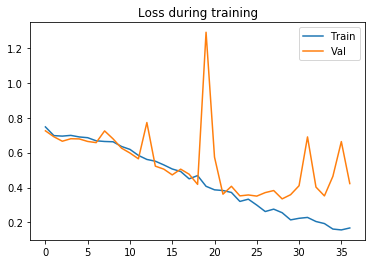

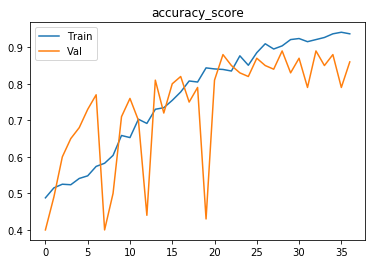

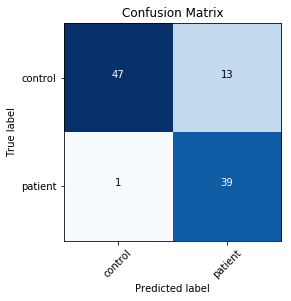

################################
################################
All accuracies: [0.87, 0.85, 0.81, 0.86]
0.8475
0.022776083947860723


In [31]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b,
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

# Start inference

In [26]:
# load models
models = []
for i in range(4):
    net = ClassificationModel3D()
    net.load_state_dict(torch.load(model_path))
    models.append(net)

In [27]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [29]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))
            output = net.forward(img)
            pred = torch.argmax(F.softmax(output, dim=1))
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.8796563573883162
Fold 1
0.862680412371134
Fold 2
0.881786941580756
Fold 3
0.8566323024054983
######## Final results ########
          0
0  0.879656
1  0.862680
2  0.881787
3  0.856632
Balanced accuracy mean 87.02 %
